# Heat Flow and Dynamic Mode Decomposition 

Dynamic mode decomposition (DMD) is used on large data sets to extract the underlying dynamical behaviour between the states in these data sets. It allows for a parameterless analysis of physical phenemona. The goal of this notebook is to take a time evolution of heat on a rod and construct the underlying modal behaviour of heat evolution on the rod in a parameterless analysis. A general statement of heatflow is that changes in temperature over time satisfy the following PDE:
\begin{equation}\tag{1}
\nabla \cdot (k\nabla u) = D \frac{\partial u}{\partial t}
\end{equation}
For the purposes of this notebook we will only consider the special 1D case where $k=D=1$:
\begin{equation}\tag{2}
\frac{\partial u}{\partial x} = \frac{\partial u}{\partial t}, \,\, 0 \leq x \leq \ell 
\end{equation}
The goal of this notebook is to take a known heat time evolution over an $\ell$ length rod and using DMD extract the underlying low rank dynamical behaviour of the data. The initial conditions we will use are as follows:

\begin{align}
u(0,t) &= u(\ell,t) = 0\\
u(x,0) & = \sin\left(\frac{x}{5}\right) 
\end{align}

The computational domain will be constructed as follows: The length of the rod will be $\ell = 10$ and the mesh will have spacing between each $x_i$ $\Delta x = 0.05$. This will lead to a solution vector $\textbf{T}$ which has size $1\times 200$ for each time step. We will take 15 time steps to perform the DMD and compare against the analytical solution. The analytical solution can easily be extracted via seperation of variables: $u(x,t) = X(x)T(t)$:

\begin{equation}
X''(x) T(t) = X(x) T'(t) \Longrightarrow \frac{X''(x)}{X(x)} = \frac{T'(t)}{T(t)} = - \lambda
\end{equation} 

This seperation yields two ODEs:

\begin{align}
X''(x) +\lambda X(x) & = 0, \,\, X(0) = X(\ell) = 0  \\
T'(t) +\lambda T(t) & = 0
\end{align} 

It can be shown that the solution in $X$ is given as 

\begin{equation}
X_n(x) = \sin\left(\frac{n \pi}{\ell} x\right),\,\, n =1, 2,3,\dots 
\end{equation} 
with corresponding eigenvalues 
\begin{equation}
\lambda_n = \left(\frac{n \pi}{\ell}\right)^2 
\end{equation} 

Thus the time domain equation has solution: 

\begin{equation}
T_n(t) = b_n \exp\left(\frac{-n^2\pi^2}{\ell^2} t\right), \,\, n = 1,2,3,\dots 
\end{equation}

Meaning the general solution to the PDE at hand is 

\begin{equation}
u(x,t) = \sum_{n=1}^{\infty} b_n \sin\left(\frac{n\pi}{\ell} x\right) \exp\left(-\frac{n^2\pi^2}{\ell^2} t\right) 
\end{equation}

Using the initial condition we obtain:

\begin{equation}
u(x,0) = \sin\left(\frac{x}{5}\right) = \sum_{n=1}^{\infty}b_n \sin\left(\frac{n\pi}{\ell}x\right) \Longrightarrow b_n \neq 0 \iff n=2
\end{equation} 

Since in our case $\ell = 10$ then $b_n = 0\,\forall n \neq 2$. Then the solution to the entire PDE is 

\begin{equation}
\boxed{u(x,t) = \sin\left(\frac{x}{5}\right) \exp\left(-\frac{4\pi^2}{100} t\right) }
\end{equation} 

which is an exponentially decaying sinusoid. From the DMD then we expect one mode, and this mode should have a negative real part and an imaginary part around $1/5$. We proceed by forming two state vectors, $T$ and $T'$ such that if $\vec{u}_i$ is the temperature on the rod at the $i$th time step, then 

\begin{equation}
T = \Big[ \vec{u}_0, \vec{u}_1, \dots, \vec{u}_{m-1} \Big] ,\,\,T' = \Big[ \vec{u}_1, \vec{u}_2, \dots, \vec{u}_m\Big]
\end{equation}

We will construct these vectors based on the analytical solution to the heat equation where $x_i = i\Delta x$ and $t=i\Delta t$. We take 150 time steps, and based on the distance $\Delta x$ we should have a $200\times 15$ matrix. We assume that the state matrices $T$ and $T'$ are related via some linear matrix $A$:

\begin{equation}
T' = A T
\end{equation}

and the eigenvalues/eigenvectors of $A$ will describe the fundamental dynamics of the data without ever referencing the heat equation! For more on this check out the note set on my GitHub on DMD. 

Below we construct the temperature measurements on the rod for each time step.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

m = 150
ell = 10
dx = 0.05
dt = 0.05
N = int(ell/dx)
x = np.linspace(0, ell, N)
T = np.zeros((N, m-1))
T_prime = np.zeros((N, m-1))

for t in range(0, m-1): 
    T[:, t] = np.sin(x/5)*np.exp(-4*(np.pi/ell)**2 * t*dt)
    
T_prime = np.roll(T, -1)
T_prime[:, m-2] = np.sin(x/5)*np.exp(-4*(np.pi/ell)**2 * (m-1)*dt)

Now that we have obtained the $T$ and $T'$ matrices, dynamic mode decomposition can be undergone. Below is a plot of the first 8 time snapshots obtained from the analytical solution (note that as the curve bends down time is increasing).

Text(0, 0.5, 'Temperature')

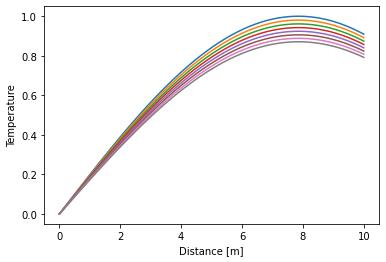

In [2]:
plt.figure()
for k in range(0, 8):
    plt.plot(x, T[:, k])

plt.xlabel('Distance [m]')
plt.ylabel('Temperature')
 

Text(0.5, 1.0, 'Singular Values of X')

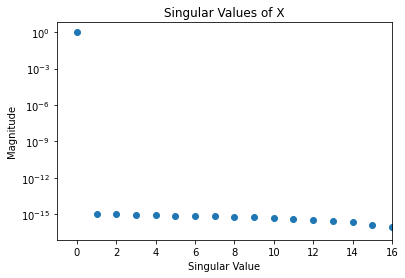

In [3]:
def SVD(X):
    
    # -- Obtain SVD for matrix X. Note Python returns V as V.conj().T, so replace V^T with V in formulas
    U, S, V = np.linalg.svd(X, full_matrices = False)
    
    S = np.diag(S)
    
    return U, S, V

U, S, V = SVD(T)

# -- Plotting 
plt.plot(np.diag(S)/np.sum(np.diag(S)), 'o')
plt.xlim(-1, 16)
plt.xlabel('Singular Value')
plt.yscale('log')
plt.ylabel('Magnitude')
plt.title('Singular Values of X')

Note that most of the variance in the data is captured by one singular value. We could even take a rank 1 truncation of the SVD if we so preferred. Let's now compute the DMD. 

In [4]:
# -- Obtain the Dynamic Mode Decomposition 
def DMD(X_prime, U, S, V):
    
    # -- Obtain truncated A matrix 
    A_tilde = (U.T)@X_prime@(V.T)@np.linalg.inv(S)

    # -- Obtain eigenvalues and eigenvectors of A 
    w, v = np.linalg.eig(A_tilde)
    
    # -- Construct eigendecomposition of A (the non truncated A). The columns of Phi are the eigenvectors of A
    Phi = X_prime@V.T@np.linalg.inv(S)@v
    
    return Phi, w, v


Phi, w, v = DMD(T_prime, U, S, V)

Now that the DMD of the temperature data has been recorded let's take a look at the DMD eigenvalues for the data as plotted below:

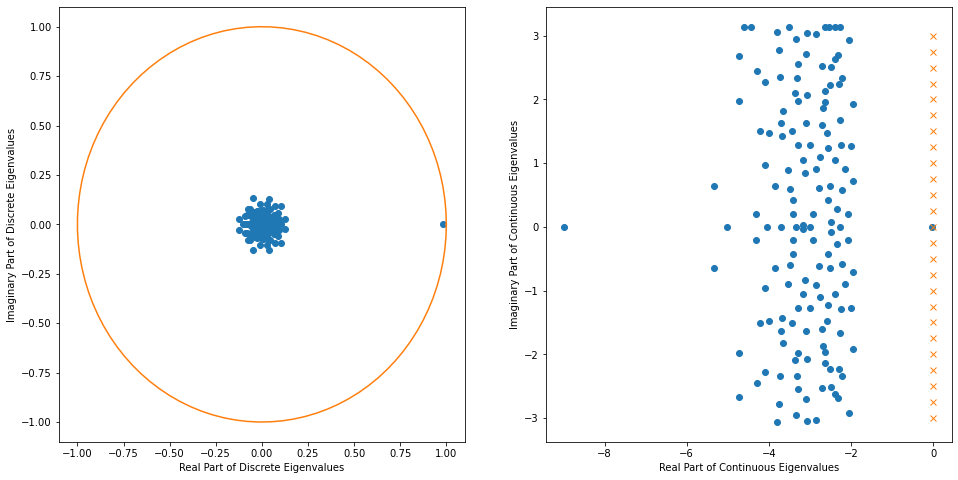

In [5]:
omega = np.log(w)
omega_r = omega.real
omega_i = omega.imag
w_r = w.real
w_i = w.imag

# -- Plotting stuff 
u = np.linspace(0, 2*np.pi, 100)
r = np.linspace(-3, 3, 25)
rx = np.zeros(25)

fig, axs = plt.subplots(1,2, figsize=(16,8))

axs[0].plot(w_r, w_i, 'o')
axs[0].set_xlabel('Real Part of Discrete Eigenvalues')
axs[0].set_ylabel('Imaginary Part of Discrete Eigenvalues')
axs[0].set_xlim(-1.1, 1.1)
axs[0].set_ylim(-1.1, 1.1)
axs[0].plot(np.cos(u), np.sin(u))

axs[1].plot(omega_r, omega_i, 'o')
axs[1].set_xlabel('Real Part of Continuous Eigenvalues')
axs[1].set_ylabel('Imaginary Part of Continuous Eigenvalues')
axs[1].plot(rx, r, 'x')

We can see one mode very close to 0,0 on the complex plane. This likely corresponds to the eigenvalue $2\pi/10$ from the analytical data and the time eigenvalue $4\pi^2/100$ from the analytical solution. We can see many other modes here, but they oscillate widely and decay fast. Consider that the decay rate of the analytical solution is $4\pi^2/100 \sim 0.4$ and these eigenvalues have real parts below $-2$ meaning that they decay at least 5 times faster than the lone eigenvalue to the right. 

We can also see how DMD results in a generalized Laplace/Z analysis. Consider how on the left hand eigenvalue plot all of the eigenvalues rest within the complex unit circle (indicating stability as in Z transform analysis) and on the right hand plot all of the complex eigenvalues rest on the left hand complex plane (indicating stability as in Laplace transform analysis). In this case the DMD can propagate the solution infinitely far into the future since there are no eigenvalues which cause exponential growth. 

Text(0, 0.5, 'DMD Eigenmode')

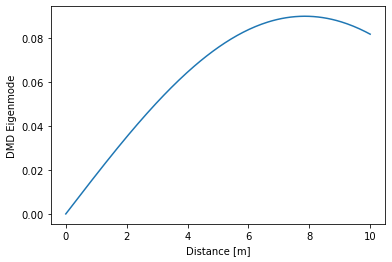

In [6]:
plt.plot(x, -Phi[:, 0].real)
plt.xlabel('Distance [m]')
plt.ylabel('DMD Eigenmode')

The columns of the $\Phi$ matrix are the eigenvectors of the dynamics of the system. This is the only non-noisey eigenmode for the DMD, and as expected it has simular shape to the exponentially damped sinusoids from the analytical solution. Plotted below is a few more modes to illustrate that they are noisey. This has to do with the singular value plot above as nearly 100 percent of the variance in the data is captured by this single mode.

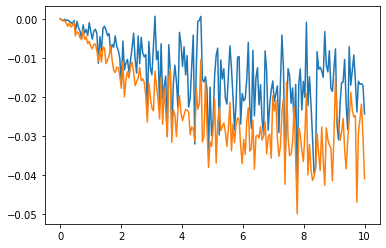

In [7]:
plt.plot(x, -Phi[:, 1].real)
plt.plot(x, -Phi[:, 5].real)

Let's now reconstruct the data and propagate it forward. 

In [8]:
# -- Compute the amplitude vector via initial condition
b = np.linalg.pinv(Phi) @ T[:, 0]

In [9]:
def DMD_reconstruct(w, phi, b):
    
    L = phi.shape[0]
    t = phi.shape[1]
    reconstructed_data = np.zeros((L,t), dtype = complex)
    
    for k in range(0, t):
        
        reconstructed_data[:, k] = phi@(b* np.exp(w * k))
    
    return reconstructed_data

T_new = DMD_reconstruct(omega, Phi, b)

# -- For a real signal the DMD reconstruction should return a real signal, just enforcing that crudely. 
T_new = np.abs(T_new)

Text(0, 0.5, 'DMD Temperature')

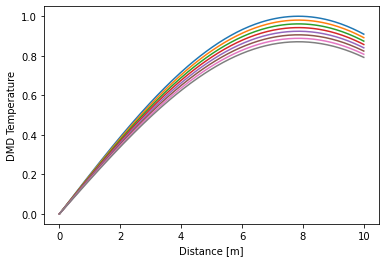

In [10]:
plt.figure()
for k in range(0, 8):
    
    plt.plot(x, T_new[:, k])
    
plt.xlabel('Distance [m]')
plt.ylabel('DMD Temperature')

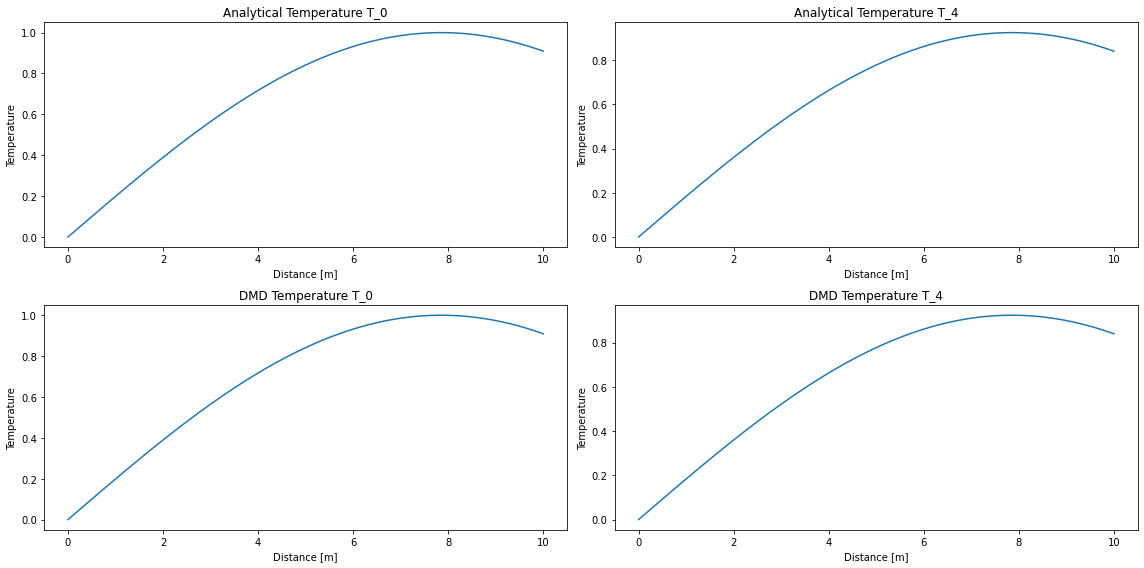

In [11]:
# -- Plotting stuff 
fig, axs = plt.subplots(2,2, figsize=(16,8))

axs[0, 0].plot(x, T[:, 0])
axs[0, 0].set_xlabel('Distance [m]')
axs[0, 0].set_ylabel('Temperature')
axs[0, 0].set_title('Analytical Temperature T_0')

axs[0, 1].plot(x, T[:, 4])
axs[0, 1].set_xlabel('Distance [m]')
axs[0, 1].set_ylabel('Temperature')
axs[0, 1].set_title('Analytical Temperature T_4')

axs[1, 0].plot(x, T_new[:, 0])
axs[1, 0].set_xlabel('Distance [m]')
axs[1, 0].set_ylabel('Temperature')
axs[1, 0].set_title('DMD Temperature T_0')

axs[1, 1].plot(x, T_new[:, 4])
axs[1, 1].set_xlabel('Distance [m]')
axs[1, 1].set_ylabel('Temperature')
axs[1, 1].set_title('DMD Temperature T_4')

fig.tight_layout() # Fixes figure layout 

To quantify the error between the analytical solution and the DMD solution, we can create:

$$T_\text{diff} = 20\log_{10}\left(\Big| T- T_\text{DMD}\Big|\right)  $$ 

and quantify the error on the dB scale. Plotted below are the errors for modes 1 through 5: 

<ipython-input-12-b61fb0f25b1b>:1: RuntimeWarning: divide by zero encountered in log
  T_diff = 20*np.log(np.abs(T-T_new))


Text(0, 0.5, 'Error in Temperature at Each Rod Point (dB)')

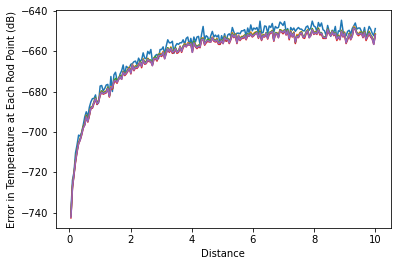

In [12]:
T_diff = 20*np.log(np.abs(T-T_new))

for k in range(1, 6):
    plt.plot(x, T_diff[:, k])

plt.xlabel('Distance')
plt.ylabel('Error in Temperature at Each Rod Point (dB)')

We can see that with errors like -600 dB that there is basically zero error between the DMD reconstruction and the analytical solution to the heat equation. We can even propagate the DMD solution forwards in time. Let's construct the DMD solution for times $t=149-160$:

Text(0.5, 1.0, 'DMD Propagation')

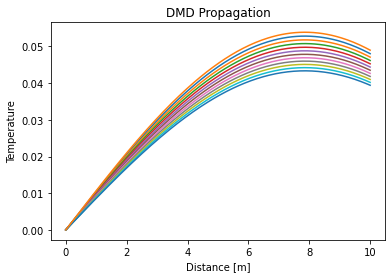

In [13]:
def DMD_propagate(w, phi, b):
    
    L = phi.shape[0]
    t = 600
    reconstructed_data = np.zeros((L,t), dtype = complex)
    
    for k in range(0, t):
        
        reconstructed_data[:, k] = phi@(b* np.exp(w * k))
    
    return reconstructed_data

T_propagate = DMD_propagate(omega, Phi, b)

# -- For a real signal the DMD reconstruction should return a real signal, just enforcing that crudely. 
T_propagate = np.abs(T_propagate)

for k in range(149, 160):
    
    plt.plot(x, T_propagate[:, k])

plt.plot(x, T[:, 148])
plt.xlabel('Distance [m]')
plt.ylabel('Temperature')
plt.title('DMD Propagation')

We can see that the solution is still decaying according to the same sinusoid. The very top curve is the analytical solution for $t=148$, the rest are propagated further by the DMD. This same analysis can be done on 2D or 3D geometries of any form, the temperature at each time step would be compressed into a column vector. This might have potential use in heat propagation studies where the geometries involved are difficult to simulate with direct numerical computation. Further, with developments of sparse DMD algorithms, not that many temperature points would have to be measured to obtain a satisfying reconstruction of the heat dynamics.

I think, theoretically at least, the DMD and heat data could be used in conjuction for a modified foreground/background analysis to extract moving heat signatures. 